In [1]:
from pytorch_libraries.utility_dataset import *
from pytorch_libraries.model_VAE import *
from IPython.display import clear_output
from pylab import *
%matplotlib inline
#%qtconsole #--style monokai

# 0. Load dataset and Model

In [18]:
trnset = np.fromfile("../data/MNIST/MNIST_train_data.dat").reshape(-1,785)

trnset[:,:-1] = trnset[:,:-1]/trnset[:,:-1].max(axis=1)[:,None]
trnset[:, -1] = trnset[:,-1]-1

model = torch.load('../data/model/MNIST_VAEcnn.pt').cuda()
#model = VAEcnn_MNIST().cuda()

trnset  = tcDataset(trnset,shape=(-1,784))
batches = DataLoader(trnset, batch_size=100, shuffle=False)

# 1. Training

In [4]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
# begin Training
for epoch in range(50):
    running_loss = 0.0
    for i, batch in enumerate(batches):
        
        # 1.get the inputs
        inputs = Variable(batch["data"]).cuda()
        # 2.zero the parameter gradients
        optimizer.zero_grad()
        # 3.forward + backward + optimize
        recons, mu, logvar = model(inputs)
        loss = loss_BCEandKLD(recons, inputs, mu, logvar, kld_factor=0.4)
        
        loss.backward()
        optimizer.step()
        
        # TRAINING DESHBOARD #
        ##################################################################
        running_loss += loss.data[0]
        if i % 100 == 99:    # print every 100 mini-batches
            print('[{:5d}, {:5d}] loss: {:5.3f}'.
                  format(epoch+1, i+1, running_loss/100))
            clear_output(wait=True)
            running_loss = 0.0
        ##################################################################

[   50,   600] loss: 8686.792


# 2. Test Decoder

In [22]:
seed   = Variable(generator_GetNormalSeed(40,32)).cuda()
images = model.decode(seed)
images = images.cpu()
images = images.data.numpy()

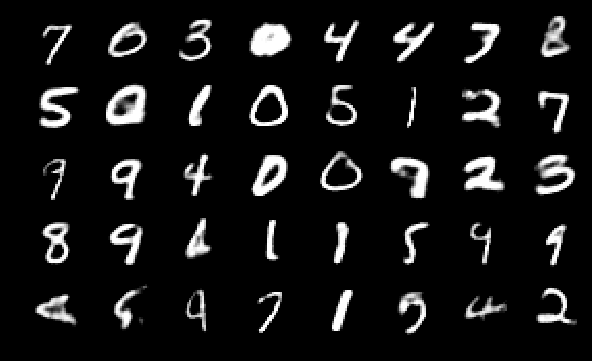

In [23]:
#fig = plt.figure()
plt.rc("figure",facecolor="k",figsize=(10,6))
plt.style.use('dark_background')
nrow = 5
ncol = 8

for row in range(nrow):
    for col in range(ncol):
        index = ncol*row + col
        plt.subplot(nrow,ncol, index+1)
        image = images[index]
        image = image.reshape(28,28).T
        plt.imshow(image,vmax=0.9,vmin=0.1,cmap='gray')
        plt.axis('off')
plt.savefig('../plot/vae_cnn.png',dpi=300)

In [10]:
torch.save(model.cpu(),'../data/model/MNIST_VAEcnn.pt') 

# 3. Continue to Train decoder with GAN

In [5]:
from pytorch_libraries.model_GAN import *

class Deflatten(nn.Module):
    def forward(self, x):
        x = x.view(-1, 100,5,5)
        return x
    
dis = DIScnn_MNIST().cuda()   
gen = nn.Sequential(model.fc4, nn.ReLU(),
                    model.fc5, nn.ReLU(),
                    model.fc6, nn.ReLU(),
                    Deflatten(),
                    model.conv3, nn.ReLU(),
                    model.conv4, nn.Sigmoid()
                   ).cuda()
dis = torch.load('../data/model/MNIST_DCGAN_DIS.pt').cuda()

In [6]:
BATCHSIZE = 100
SEEDDIM = 32
# define target
target_real = Variable(torch.ones(BATCHSIZE,1)).cuda()
target_fake = Variable(torch.zeros(BATCHSIZE,1)).cuda()
# define optimizer
gen_optimizer = optim.Adam(gen.parameters(), lr=2e-4)
dis_optimizer = optim.Adam(dis.parameters(), lr=2e-4)

In [7]:

gen.train()
dis.train()

# begin Training
for epoch in range(20):
    running_gen_loss = 0.0
    running_dis_loss = 0.0
    for i, batch in enumerate(batches):
        
        # 1. training dis
        dis_optimizer.zero_grad()
        
        # 1.1 get input
        inputs_real = Variable(batch["data"]).cuda()
        gen_seed    = Variable(generator_GetNormalSeed(BATCHSIZE,SEEDDIM)).cuda()
        inputs_fake = gen(gen_seed)
        
        # 1.2 get scores for real and fake
        score_real = dis(inputs_real *2-1)
        score_fake = dis(inputs_fake *2-1)
        
        # 1.3 calc loss
        dis_loss = discriminator_loss(score_real, score_fake, 
                                      target_real,target_fake)
        # 1.4 backprop and optimize
        dis_loss.backward()
        dis_optimizer.step()
        
        # 2. training gen
        gen_optimizer.zero_grad()
        
        gen_seed = Variable(generator_GetNormalSeed(BATCHSIZE,SEEDDIM)).cuda()
        gen_loss = generator_loss( dis(gen(gen_seed) *2-1), target_real)        
        
        gen_loss.backward()
        gen_optimizer.step()   
          

        # TRAINING DESHBOARD #
        ##################################################################
        running_gen_loss += gen_loss.data[0]
        running_dis_loss += dis_loss.data[0]
        if i % 100 == 99:    # print every 100 mini-batches
            print('[{:5d}, {:5d}] gen-loss: {:8.6f}, dis-loss: {:8.6f}'.
                  format(epoch+1, i+1, running_gen_loss/100, running_dis_loss/100))
            clear_output(wait=True)
            running_gen_loss = 0.0
            running_dis_loss = 0.0
        ##################################################################

[   20,   600] gen-loss: 5.563258, dis-loss: 0.125762


# 4. Test Final Decoder

In [19]:
seed   = Variable(generator_GetNormalSeed(40,32))#.cuda()
images = gen(seed)
images = images.cpu()
images = images.data.numpy()

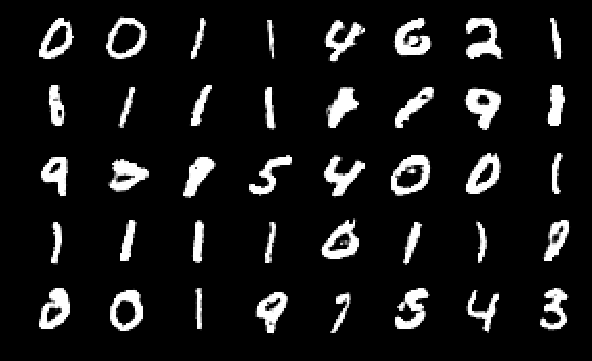

In [20]:
#fig = plt.figure()
plt.rc("figure",facecolor="k",figsize=(10,6))
plt.style.use('dark_background')
nrow = 5
ncol = 8

for row in range(nrow):
    for col in range(ncol):
        index = ncol*row + col
        plt.subplot(nrow,ncol, index+1)
        image = images[index]
        image = image.reshape(28,28).T
        plt.imshow(image,vmax=0.9,vmin=0.1,cmap='gray')
        plt.axis('off')
plt.savefig('../plot/vae_DCGAN.png',dpi=300)

In [10]:
torch.save(gen.cpu(),'../data/model/MNIST_VAE_DCGAN_gen.pt') 
torch.save(dis.cpu(),'../data/model/MNIST_VAE_DCGAN_dis.pt') 

/Users/zihengchen/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Deflatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
